# TP Perceptron multicouches (data)

Un perceptron multicouches (*multilayer perceptron*, MLP) est un système d'apprentissage automatique à base de réseaux de neurones. Nous allons l'utiliser dans un mode qui lui permet de détecter une corrélation entre des paramètres en essayant d'apprendre la loi de probabilité qui les relie.

* FIXME vocabulaire, peut-on / doit-on parler de *régression non-linéaire* dans ce contexte ?

Dans ce TP nous utiliserons les bibliothèques et jeux de données suivants.

In [1]:
# Bibliothèques.
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

# Préchargement des jeux de données.
df_1photon_x = pd.read_csv('datasets/jour1-1-facile/1photon-polar-x-intervalles.csv', sep=';')
df_1photon_x_angles_alea = pd.read_csv('datasets/jour1-1-facile/1photon-polar-x-alea.csv', sep=';')
df_1photon_y = pd.read_csv('datasets/jour1-1-facile/1photon-polar-y-intervalles.csv', sep=';')
df_1photon_45 = pd.read_csv('datasets/jour1-1-facile/1photon-polar-45-intervalles.csv', sep=';')

## Principe de la méthode appliquée à nos mesures

### Estimation de la probabilité empirique

La première étape est d'estimer la probabilité d'observation en fonction des paramètres expérimentaux, à partir des résultats empiriques contenus dans le jeu de données. Dans notre cas on observe la détection sur X (1) ou non (0), avec un détecteur tourné d'un certain angle qui est le seul paramètre variable. Il peut prendre des valeurs aléatoires, ou un petit nombre de valeurs espacées régulièrement avec plusieurs répétitions pour chaque valeur. Dans le second cas, on comptera le nombre de détections pour chaque valeur unique de l'angle ; dans le premier, on les comptera dans des intervalles («bins»), comme pour un histogramme.

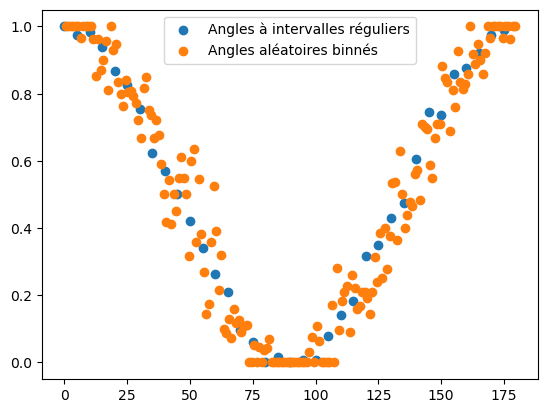

In [2]:
# Angles réguliers : extraire les valeurs uniques, compter les détections.
data = df_1photon_x
angles = np.unique(data.alpha) # Ou directement data.alpha.unique(), moins générique.
nb_angles = angles.shape[0]
proba = np.empty((nb_angles,))
for k, alpha_k in enumerate(angles):
    select_alpha_k = (data.alpha == alpha_k)
    proba[k] = (select_alpha_k & (data.X == 1)).sum() / select_alpha_k.sum()

plt.scatter(angles, proba, label = 'Angles à intervalles réguliers')

# Angles aléatoires : faire l'histogramme des détections dans des intervalles d'angles.
# Les angles seront les centres des intervalles.
data = df_1photon_x_angles_alea
nb_angles = 180
angles_nb_per_bin, angles_bins = np.histogram(data.alpha, bins = nb_angles, range = (0, 180))
angles = (angles_bins[1:] + angles_bins[:-1]) * 0.5
proba = np.empty((nb_angles,))
for k in range(nb_angles):
    select_alpha_k = ((data.alpha >= angles_bins[k]) & (data.alpha < angles_bins[k+1]))
    proba[k] = (select_alpha_k & (data.X == 1)).sum() / angles_nb_per_bin[k]

plt.scatter(angles, proba, label = 'Angles aléatoires binnés')
_ = plt.legend()

### Entraînement du MLP et estimation du score

Une fois calculée la probabilité empirique en fonction de l'angle, on va séparer les tableaux en deux parties : une servira à l'entraînement (p. ex. 75% des données), l'autre au test, c'est-à-dire à estimer si la loi de probabilité apprise par le MLP prédit effectivement les données de test.
S'il y a effectivement une corrélation entre le paramètre et l'observation, le MLP a des chances de la détecter de façon à faire des prédictions correctes (avec un score proche de 1). Dans le cas contraire, la loi apprise ne sera qu'un artefact et fera des prédictions qui n'auront aucun rapport avec la probabilité empirique (le score sera faible).

La séparation des données en 2 parties pourra être effectuée en découpant les tableaux à la main ou, mieux, par la fonction `train_test_split`, qui par défaut les permute aléatoirement (inutile si les angles sont aléatoires, indispensable s'ils varient régulièrement ou sont issus d'un binning).

Le MLP dans cette application est implémenté par la classe `MLPRegressor`. On doit préciser le nombre et la taille des couches cachées dans le réseau de neurones. On peut commencer par des valeurs génériques, on pourra ci-dessous jouer avec les possibilités.


Les angles devront être convertis en radians.
* FIXME pourquoi le MLP fonctionne-t-il mal avec les degrés ?

L'apprentissage étant aléatoire, on pourra recommencer plusieurs fois.
(Mais voir l'étape de validation croisée ci-dessous.)

Score = 0.7814998268106739


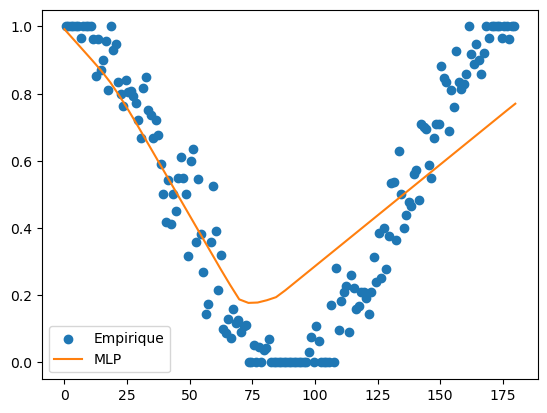

In [3]:
# Partitionner en jeux de données d'entraînement et de test.
# Le tableau de l'angle doit être 2D (car l'interface doit pouvoir
# fonctionner avec plusieurs paramètres variant simultanément).
train_angles, test_angles, train_obs, test_obs = train_test_split(
    np.radians(angles).reshape(-1, 1),
    proba,
    shuffle = True # Vrai par défaut ; essayez avec False pour voir...
)
mlp = MLPRegressor(solver = 'adam',
                   hidden_layer_sizes = (30, 30),
                   max_iter = 2000)
mlp.fit(train_angles, train_obs)
print(f'Score = {mlp.score(test_angles, test_obs)}')

# Tracer la loi de probabilité prédite et la probabilité empirique.
plot_angles = np.linspace(0, 180)
plt.scatter(angles, proba, label = 'Empirique')
plt.plot(plot_angles, mlp.predict(np.radians(plot_angles).reshape(-1, 1)),
         label = 'MLP', color = 'tab:orange')

_ = plt.legend()

### Validation croisée

L'apprentissage du MLP est régi par des paramètres spécifiques — on parle d'*hyper-paramètres*, par opposition aux paramètres intrinsèques de la loi de probabilité recherchée.
Il est nécessaire de jouer sur ces hyper-paramètres pour optimiser l'apprentissage.

Pour ce faire, il serait tentant d'optimiser directement le score obtenu avec les données de test et choisir les hyper-paramètres ayant obtenu le meilleur score, mais ce n'est pas une bonne pratique. **(Question : pourquoi, méthodologiquement, doit-on se l'interdire ?)**

À la place, sans rentrer dans le détail, on introduit une étape supplémentaire où les données d'entraînement sont à nouveau partitionnées de plusieurs façons différentes, des scores intermédiaires sont calculés, et on optimise la moyenne de ces scores.

Cette technique de *validation croisée* est implémentée par la classe `GridSearchCV`.
L'hyper-paramètre de `MLPRegressor` à optimiser est `alpha`, qu'on pourra tester sur
plusieurs ordres de grandeur de $10^{-1}$ à $10^{-4}$.

De plus, vu l'aléa, on pourra répéter l'opération plusieurs fois pour tester.

MLPRegressor(alpha=9.999999999999999e-05, hidden_layer_sizes=(30, 30),
             max_iter=2000)
Score 1 = 0.9268225826596734
Score 2 = 0.7755305024803901
Score 3 = 0.9067852428288179
Score 4 = 0.9363860200759415
Score 5 = 0.9105968210435975
Score 6 = 0.7673630591812108
Score 7 = 0.9265747552212945
Score 8 = 0.8291953349540044


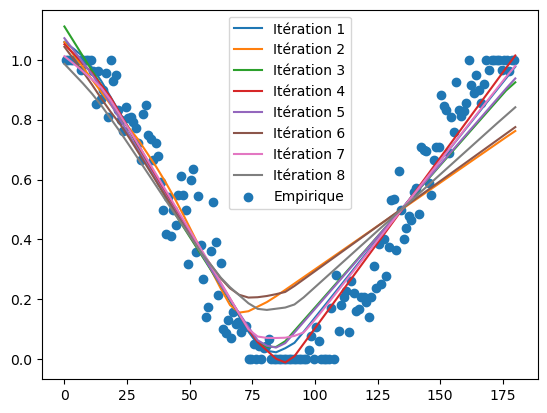

In [ ]:
# Jeux de test initialisés ci-dessus, ainsi que plot_angles.
# Initialisation de la validation croisée.
grid = GridSearchCV(MLPRegressor(solver = 'adam',
                                 hidden_layer_sizes=(30, 30),
                                 max_iter = 2000),
                    {'alpha': 10. ** -np.arange(1, 5)},
                    cv = 3)
grid.fit(train_angles, train_obs)
print(grid.best_estimator_)

# Tester plusieurs fois, tracer la loi de probabilité prédite.
for k in range(1, 9):
    grid.fit(train_angles, train_obs)
    print(f'Score {k} = {grid.score(test_angles, test_obs)}')
    plt.plot(plot_angles, grid.predict(np.radians(plot_angles).reshape(-1, 1)),
             label = f'Itération {k}')

# Tracer la probabilité empirique.
plt.scatter(angles, proba, label = 'Empirique')
_ = plt.legend()

## À vous de jouer : questions

* Testez plusieurs tailles de réseau de neurones, de (5, 5) à (30, 30).
* Testez sur des jeux de données bruités, commentez le score en fonction du niveau de bruit.
* Testez sur `datasets/jour1-3-difficile/1photon-polar-circ.csv`.